In [13]:
import sys
from bs4 import BeautifulSoup as Soup
from collections import Counter
from collections import defaultdict
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

import pyspark
import numpy as np
from pyspark import SparkContext
from pyspark.mllib.fpm import FPGrowth

# SparkContext.setSystemProperty('spark.executor.memory','3g')
# sc = pyspark.SparkContext('local[*]')


#import timestring

posts_by_tag = defaultdict()
tags_by_year = defaultdict()
tags_by_post_id = defaultdict()
tags=list()


def populate_posts_by_tag(tag,post_id):
    global posts_by_tag
    if tag == '':
        return
    if post_id == '':
        return

    if tag not in posts_by_tag:
        posts_by_tag[tag] = set()
    posts_by_tag[tag].add(int(post_id))

def populate_tags_by_post_id(id,tag):
    global tags_by_post_id
    if tag == '':
        return
    if id == '':
        return

    if id not in tags_by_post_id:
        tags_by_post_id[id] = list()
    tags_by_post_id[id].append(tag)
    
def populate_tags_by_year(tag,year):
    global tags_by_year
    if tag == '':
        return
    if year == '':
        return

    if tag not in tags_by_year:
        tags_by_year[tag] = list()
    tags_by_year[tag].append(year)

def plot_tags(tagCount):
    
    x,y = zip(*tagCount)

    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colors = [colormap(i) for i in np.linspace(0, 0.8,50)]   

    area = [i/100 for i in list(y)]   # 0 to 15 point radiuses
    plt.figure(figsize=(8,8))
    plt.ylabel("Number of question associations")
    for i in range(len(y)):
        plt.plot(i+0.5,y[i], marker='o', linestyle='',ms=area[i],label=x[i])

    plt.legend(numpoints=1)
    plt.show()
    
def parseLog(file):
    count=0
    with open(file, encoding='utf8') as handler:
        soup = Soup(handler,"html.parser")
        for message in soup.findAll('row'):
            msg_attrs = dict(message.attrs)
            #print(msg_attrs['id'])
            if 'tags' in msg_attrs:
                id = msg_attrs['id']
                year =  msg_attrs['creationdate'].split("-")[0]
                #print(year)
                msg_attrs=(msg_attrs[u'tags'].replace('<','').replace('>',','))
                for msg in msg_attrs.split(','):
                    tags.append(msg)
                    populate_posts_by_tag(msg,id)
                    populate_tags_by_year(msg,year)
                    populate_tags_by_post_id(id,msg)
                    
                #count=count+1

            # if count == 5:
            #     break

#### Inspect top 20 tags for this data set.

In [15]:
parseLog("programmers.stackexchange.com/Posts.xml")
tags=list(filter(None, tags))
counts=dict()
#counts=Counter(tags)

top_20_words = Counter(tags).most_common(20)
print(top_20_words)
#print(posts_by_tag)


[('java', 3511), ('c#', 3007), ('design', 2886), ('design-patterns', 2475), ('object-oriented', 2036), ('c++', 1822), ('algorithms', 1732), ('php', 1667), ('architecture', 1639), ('javascript', 1578), ('licensing', 1269), ('database', 1256), ('web-development', 1223), ('programming-languages', 1205), ('python', 1183), ('programming-practices', 1167), ('.net', 1084), ('unit-testing', 1063), ('c', 958), ('testing', 956)]


[('java', 3511), ('c#', 3007), ('design', 2886), ('design-patterns', 2475), ('object-oriented', 2036), ('c++', 1822), ('algorithms', 1732), ('php', 1667), ('architecture', 1639), ('javascript', 1578)]


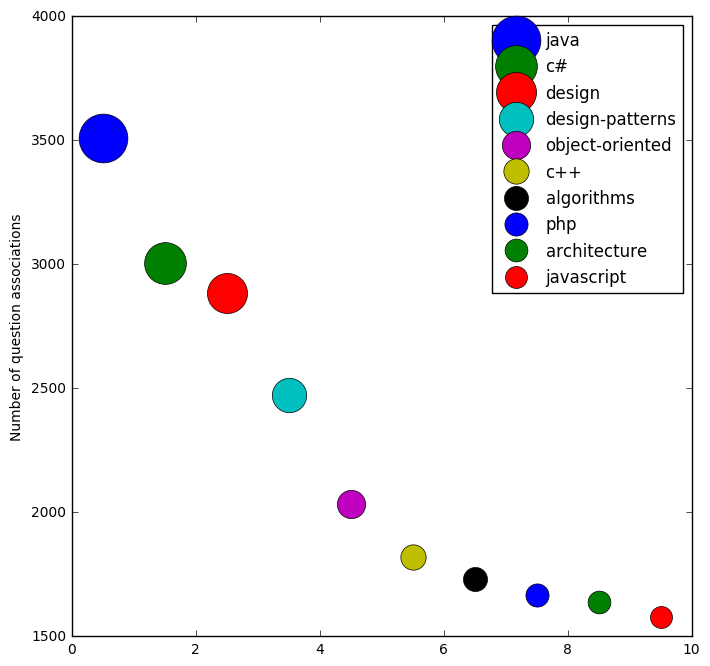

In [16]:
import collections
import numpy as np
tagCount =  collections.Counter(list(tags)).most_common(10)
print(tagCount)
plot_tags(tagCount)

#### Plot popularity of top 20 tags over recent years

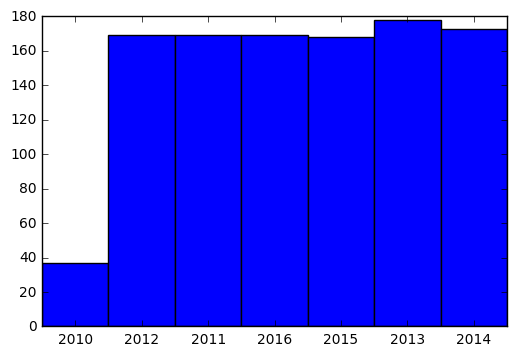

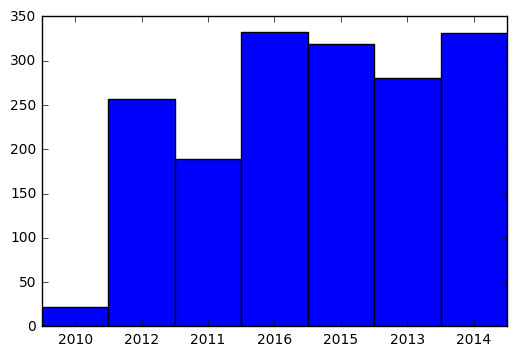

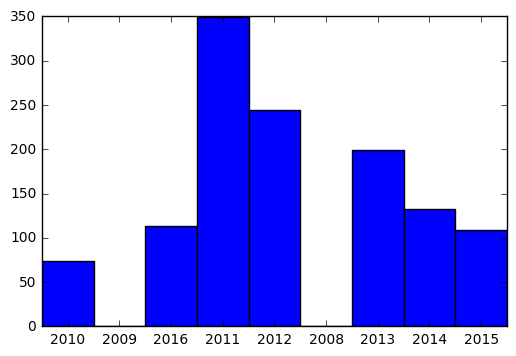

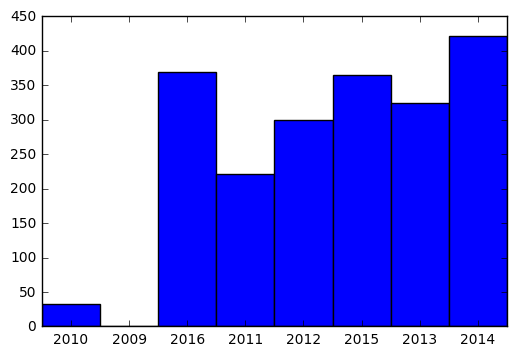

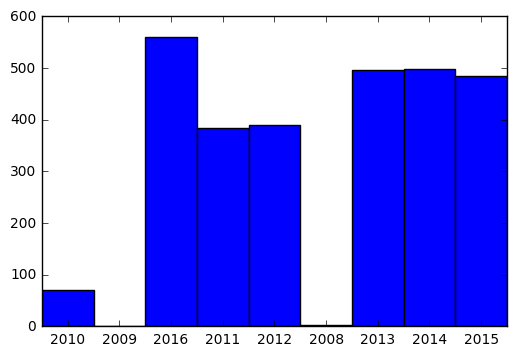

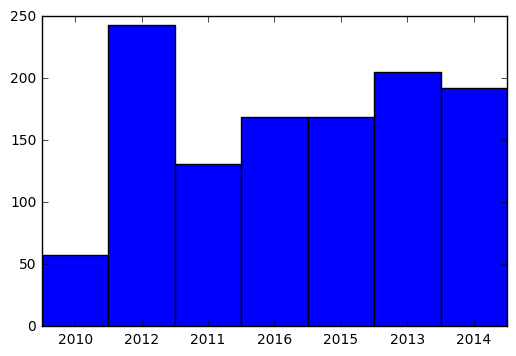

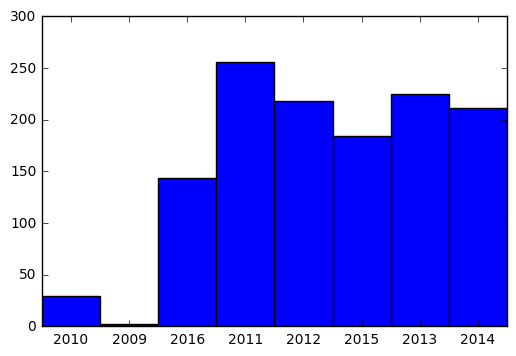

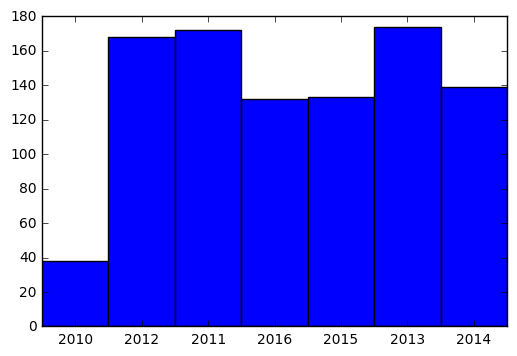

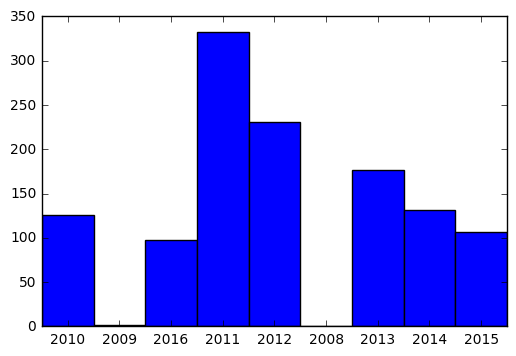

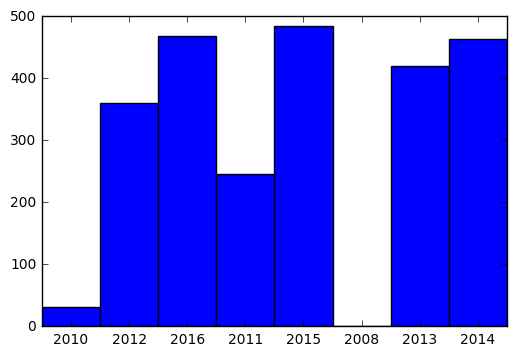

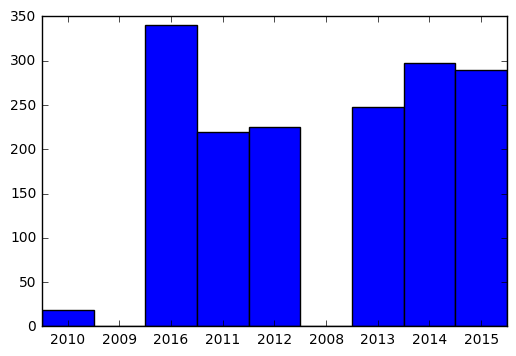

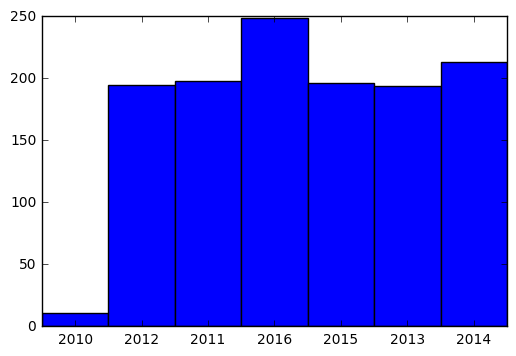

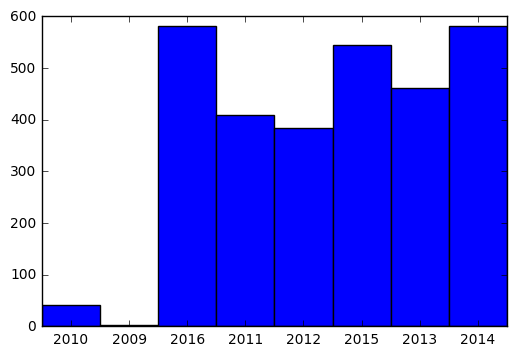

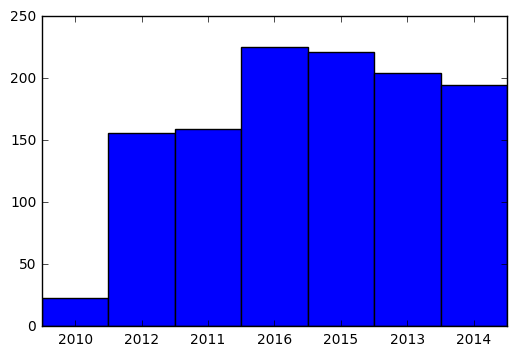

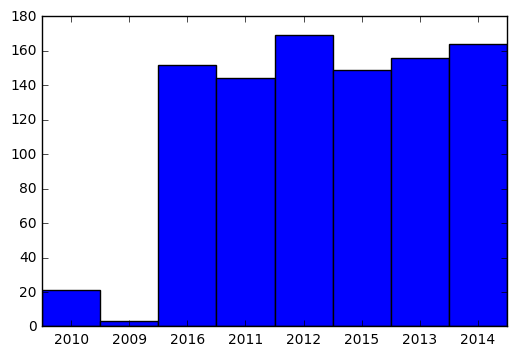

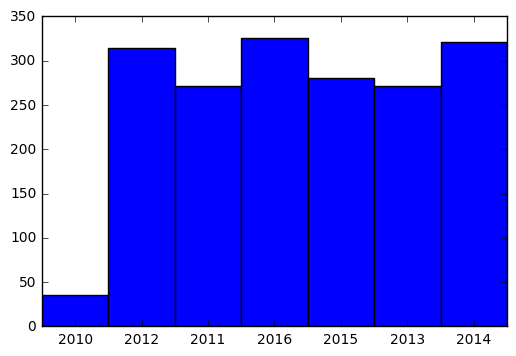

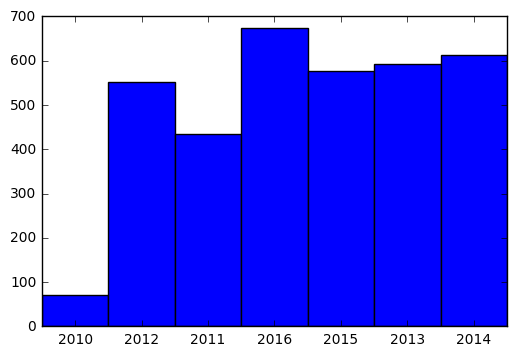

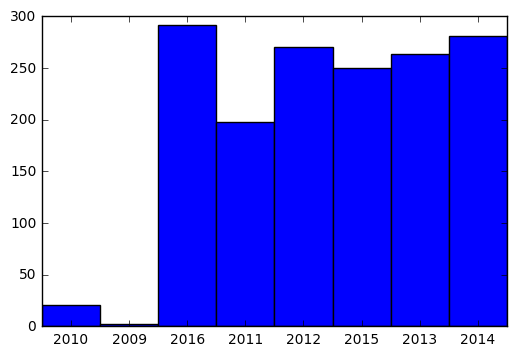

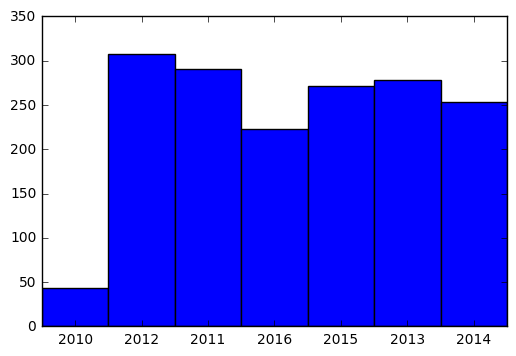

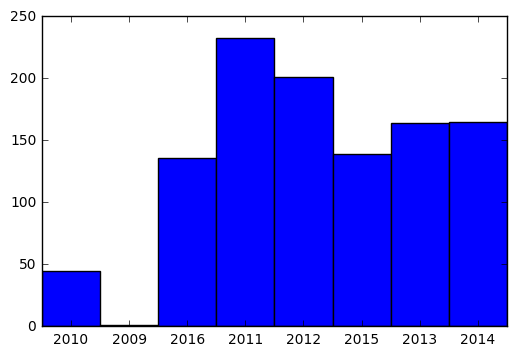

In [11]:
top_20_dict = dict()
for key in top_20_words:
    top_20_dict[key[0]] = Counter(tags_by_year[key[0]])
    
for tag in top_20_dict:
    labels, values = zip(*top_20_dict[tag].items())
    indexes = np.arange(len(labels))
    width = 1
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

#### Frequent Item Sets analysis for tags

In [12]:
import csv
fp = open("output.txt", "w")
for key, val in tags_by_post_id.items():
    fp.write(' '.join(str(e) for e in val))
    fp.write("\n")

data = sc.textFile("output.txt")
transactions = data.map(lambda line: line.strip().split(' '))
model = FPGrowth.train(transactions, minSupport=0.005, numPartitions=2)
result = model.freqItemsets().collect()
# Print only frequent item sets with >1
for fi in result:
    if len(fi.items)> 1:
        print(fi)

FreqItemset(items=['architecture', 'design'], freq=345)
FreqItemset(items=['scrum', 'agile'], freq=318)
FreqItemset(items=['open-source', 'licensing'], freq=320)
FreqItemset(items=['design', 'c#'], freq=257)
FreqItemset(items=['design', 'java'], freq=307)
FreqItemset(items=['gpl', 'licensing'], freq=352)
FreqItemset(items=['object-oriented', 'design'], freq=354)
FreqItemset(items=['object-oriented', 'design-patterns'], freq=390)
FreqItemset(items=['object-oriented', 'java'], freq=289)
FreqItemset(items=['object-oriented-design', 'object-oriented'], freq=225)
FreqItemset(items=['object-oriented-design', 'design-patterns'], freq=258)
FreqItemset(items=['.net', 'c#'], freq=451)
FreqItemset(items=['c', 'c++'], freq=226)
FreqItemset(items=['tdd', 'unit-testing'], freq=239)
FreqItemset(items=['database-design', 'database'], freq=219)
FreqItemset(items=['testing', 'unit-testing'], freq=257)
FreqItemset(items=['design-patterns', 'design'], freq=475)
FreqItemset(items=['design-patterns', 'c#'],

#### TF-IDF matrix creation for post data, and subsequent KMeans Clustering

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer( max_features=200000, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(posts_by_tag.keys())

print(tfidf_matrix.shape)

NameError: name 'posts_by_tag' is not defined

In [5]:
terms = tfidf_vectorizer.get_feature_names()


In [6]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [7]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 810 ms, sys: 14.3 ms, total: 824 ms
Wall time: 510 ms
